In [394]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [395]:
# Importing the dataset
df = pd.read_csv('continuous dataset.csv', parse_dates=['datetime'])
df.set_index('datetime', inplace=True)

# Formatting index to date format and taking only the date part
df.index = df.index.date

# Taking the mean of the values for each day
df = df.groupby(df.index).mean()

df.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
2020-06-23,1137.366342,28.212134,0.020796,0.064456,9.059754,27.373593,0.020025,0.071319,3.063794,25.106015,0.019313,0.140443,3.298566,0.0,0.0,1.0
2020-06-24,1131.196625,27.961924,0.019846,0.068500,6.366136,26.937836,0.019451,0.067418,4.563275,24.801768,0.018028,0.104188,2.209644,0.0,0.0,1.0
2020-06-25,1184.028708,27.874629,0.020355,0.037643,14.397304,27.097936,0.019417,0.117533,3.576064,25.025671,0.018032,0.187870,2.053162,0.0,0.0,1.0
2020-06-26,1106.277696,27.641224,0.020038,0.088381,12.387819,26.443959,0.019544,0.111448,3.959654,24.311797,0.018276,0.191958,2.372862,0.0,0.0,1.0
2020-06-27,1013.568300,26.750330,0.020441,0.063965,10.198346,25.125330,0.019281,0.100189,2.785751,23.562830,0.018404,0.162598,3.286878,0.0,0.0,1.0


In [396]:
df.shape

(2003, 16)

In [397]:
# Print max and min date
print(df.index.min())  
print(df.index.max())

2015-01-03
2020-06-27


In [398]:
correlation_matrix = df.corr()
print("Correlation with nat_demand:\n", correlation_matrix['nat_demand'].sort_values(ascending=False))

selected_features = correlation_matrix['nat_demand'][abs(correlation_matrix['nat_demand']) > 0.1].index
filtered_data = df[selected_features]
filtered_data.head()

Correlation with nat_demand:
 nat_demand    1.000000
T2M_toc       0.152730
T2M_dav       0.140247
T2M_san       0.111742
school        0.081409
QV2M_toc      0.072124
QV2M_dav      0.065612
QV2M_san      0.048114
W2M_toc      -0.007018
W2M_san      -0.040861
W2M_dav      -0.081931
TQL_dav      -0.095661
TQL_san      -0.125282
TQL_toc      -0.164687
Holiday_ID   -0.265357
holiday      -0.338629
Name: nat_demand, dtype: float64


,nat_demand,T2M_toc,TQL_toc,T2M_san,TQL_san,T2M_dav,Holiday_ID,holiday
2015-01-03,1069.266587,27.837319,0.006561,26.481001,0.010949,24.812523,0.0,0.0
2015-01-04,1008.123596,27.385723,0.003788,26.250307,0.013746,24.195294,0.0,0.0
2015-01-05,1146.682925,27.174477,0.013344,26.022784,0.016091,24.078774,0.0,0.0
2015-01-06,1143.394429,27.003596,0.010847,25.909521,0.015202,23.811539,0.0,0.0
2015-01-07,1144.098817,26.678420,0.017465,25.205438,0.025092,23.243199,0.0,0.0


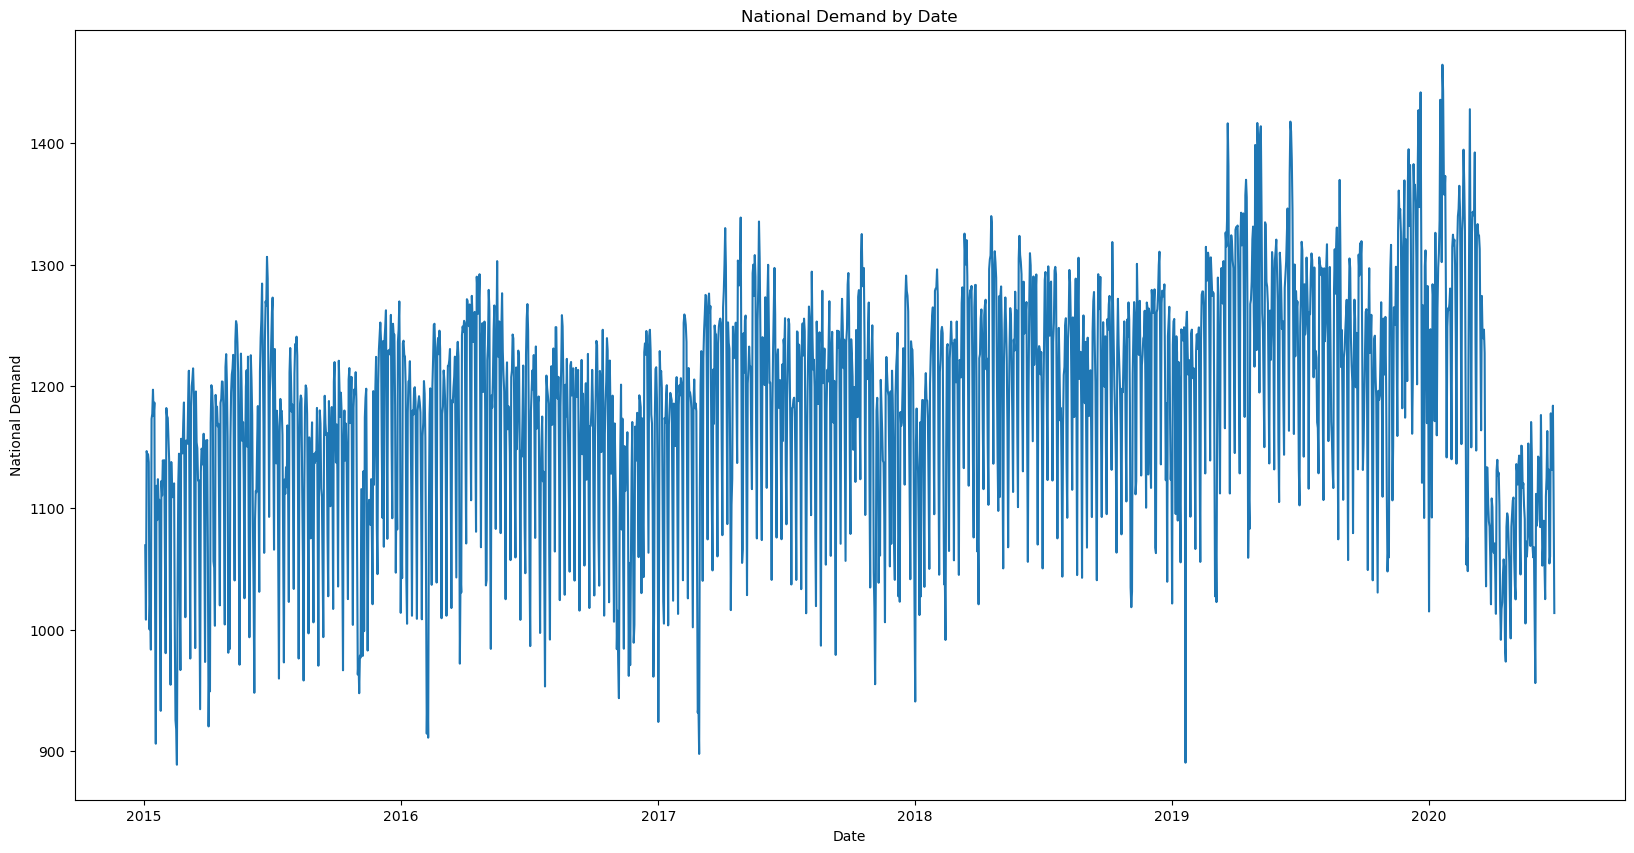

In [399]:
# Plotting the nat_demand by date and using a trendline to show the trend
plt.figure(figsize=(20,10))
plt.plot(filtered_data['nat_demand'])
plt.title('National Demand by Date')
plt.xlabel('Date')
plt.ylabel('National Demand')
plt.show()


In [400]:
filtered_data.shape

(2003, 8)

In [401]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(filtered_data)
print(data_scaled)


[[0.31347935 0.50909413 0.01745311 ... 0.44401427 0.         0.        ]
 [0.20722748 0.4071022  0.00888319 ... 0.32633347 0.         0.        ]
 [0.44801039 0.35939265 0.03841459 ... 0.30411781 0.         0.        ]
 ...
 [0.51290842 0.51752044 0.11350854 ... 0.48465293 0.         0.        ]
 [0.37779579 0.46480648 0.27030696 ... 0.34854598 0.         0.        ]
 [0.21668907 0.26359993 0.19485101 ... 0.20574802 0.         0.        ]]


In [402]:
# Define the number of candles to look back
X = []
backcandles = 20

# Define the target
for j in range(8): 
    X.append([])
    for i in range(backcandles, data_scaled.shape[0]):
        X[j].append(data_scaled[i-backcandles:i, j])

X

[[array([0.31347935, 0.20722748, 0.44801039, 0.44229578, 0.44351983,
         0.43220351, 0.19340771, 0.23575621, 0.16445457, 0.49412798,
         0.50130022, 0.53573725, 0.4985342 , 0.51736513, 0.22876145,
         0.03004192, 0.39853877, 0.34940928, 0.40791127, 0.37464696]),
  array([0.20722748, 0.44801039, 0.44229578, 0.44351983, 0.43220351,
         0.19340771, 0.23575621, 0.16445457, 0.49412798, 0.50130022,
         0.53573725, 0.4985342 , 0.51736513, 0.22876145, 0.03004192,
         0.39853877, 0.34940928, 0.40791127, 0.37464696, 0.37847236]),
  array([0.44801039, 0.44229578, 0.44351983, 0.43220351, 0.19340771,
         0.23575621, 0.16445457, 0.49412798, 0.50130022, 0.53573725,
         0.4985342 , 0.51736513, 0.22876145, 0.03004192, 0.39853877,
         0.34940928, 0.40791127, 0.37464696, 0.37847236, 0.19477131]),
  array([0.44229578, 0.44351983, 0.43220351, 0.19340771, 0.23575621,
         0.16445457, 0.49412798, 0.50130022, 0.53573725, 0.4985342 ,
         0.51736513, 0.22876

In [403]:
# Move axis 
X=np.moveaxis(X, [0], [2])
X

array([[[0.31347935, 0.50909413, 0.01745311, ..., 0.44401427,
         0.        , 0.        ],
        [0.20722748, 0.4071022 , 0.00888319, ..., 0.32633347,
         0.        , 0.        ],
        [0.44801039, 0.35939265, 0.03841459, ..., 0.30411781,
         0.        , 0.        ],
        ...,
        [0.34940928, 0.31103665, 0.19528818, ..., 0.31753957,
         0.        , 0.        ],
        [0.40791127, 0.15553857, 0.31034946, ..., 0.1639258 ,
         0.        , 0.        ],
        [0.37464696, 0.21128716, 0.36812619, ..., 0.27733464,
         0.        , 0.        ]],

       [[0.20722748, 0.4071022 , 0.00888319, ..., 0.32633347,
         0.        , 0.        ],
        [0.44801039, 0.35939265, 0.03841459, ..., 0.30411781,
         0.        , 0.        ],
        [0.44229578, 0.32079964, 0.03069911, ..., 0.25316689,
         0.        , 0.        ],
        ...,
        [0.40791127, 0.15553857, 0.31034946, ..., 0.1639258 ,
         0.        , 0.        ],
        [0.3

In [404]:
# Define the target
X, yi =np.array(X), np.array(data_scaled[backcandles:,0])
y=np.reshape(yi,(len(yi),1))

#print(X)
print(X.shape)
#print(y)
print(y.shape)

(1983, 20, 8)
(1983, 1)


In [405]:
# split data into train test sets
splitlimit = int(len(X)*0.8) # 80% train, 20% test
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1586
(1586, 20, 8)
(397, 20, 8)
(1586, 1)
(397, 1)
[[0.37847236]
 [0.19477131]
 [0.07698809]
 ...
 [0.59100579]
 [0.42186476]
 [0.72059797]]


In [406]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
lstm_model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
lstm_model.compile(optimizer=adam, loss='mse')
lstm_model.fit(x=X_train, y=y_train, batch_size=100, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0889 - val_loss: 0.0698
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0287 - val_loss: 0.0351
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0223 - val_loss: 0.0270
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0194 - val_loss: 0.0237
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0182 - val_loss: 0.0214
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0182 - val_loss: 0.0226
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0180 - val_loss: 0.0233
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0181 - val_loss: 0.0220
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0182 - val_loss: 0.0224
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0176 - val_loss: 0.0231
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0180 - val_loss: 0.0196
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0

In [407]:
y_pred = lstm_model.predict(X_test)
for i in range(20):
    print(y_pred[-i], y_test[-i])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.635967] [0.73361525]
[0.37804735] [0.21668907]
[0.44231117] [0.37779579]
[0.45079237] [0.51290842]
[0.47791478] [0.42109892]
[0.48349458] [0.4318204]
[0.40166125] [0.50198954]
[0.34674948] [0.29763714]
[0.35147935] [0.28749117]
[0.3729284] [0.42171846]
[0.4333962] [0.39422108]
[0.43828028] [0.47671729]
[0.416444] [0.41007173]
[0.3626597] [0.38334472]
[0.37435725] [0.23651849]
[0.37633353] [0.28657872]
[0.36328387] [0.34855118]
[0.41797736] [0.31029213]
[0.46470073] [0.28439329]
[0.48083088] [0.39823996]


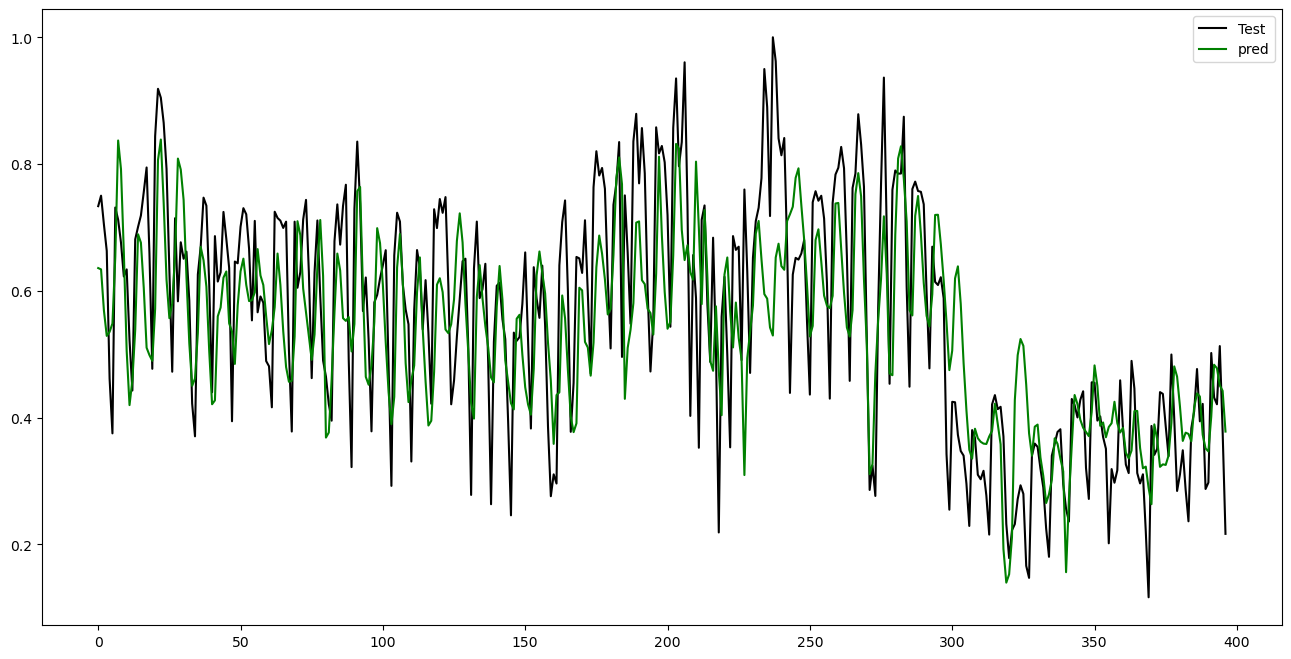

In [408]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [410]:
# Getting mae and rmse
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae =  round(mean_absolute_error(y_test, y_pred),2)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 0.1
RMSE: 0
